# Credit Card Fraud Detection: Using Random Forest



In [1]:

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import SGDClassifier

# from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Self-built Random Forest Classifier

Random forest is a type of ensemble learning method that combines multiple decision trees to make predictions for classification or regression tasks. It works by constructing multiple decision trees on randomly selected subsets of the training data and using the combined predictions of all trees to make a final prediction.

We can build a custom class called _RandomForestClassifier_ to train and predict values for the dataset. The class constructor takes several optional parameters, including n_estimators, max_depth, min_samples_split, and max_features. 

The n_estimators parameter controls the number of decision trees to be constructed. The max_depth and min_samples_split parameters control the maximum depth of each tree and the minimum number of samples required to split an internal node, respectively. The max_features parameter controls the number of features to consider when splitting each internal node.

The _fit()_ function takes the training data X and its corresponding labels y, and trains the model by constructing multiple decision trees using the _DecisionTreeClassifier_ and combining their predictions using a majority vote.

The _predict()_ function takes an input array X and returns an array of predictions based on the trained random forest model.

The random forest algorithm works by randomly selecting a subset of the training data and a subset of the features for each decision tree. This helps to reduce overfitting and improve the generalization of the model. The algorithm then constructs each decision tree independently and combines their predictions using a majority vote.

The _DecisionTreeClassifier_ class described earlier is used to construct each decision tree in the random forest. The main difference is that the _best_split()_ function in the _DecisionTreeClassifier_ class considers only a subset of the available features for each split, as determined by the max_features parameter.

In addition to the _fit()_ and _predict()_ functions, the _RandomForestClassifier_ class may also include functions for calculating feature importance and visualizing the decision trees in the forest.

In [33]:
class RandomForestClassifier:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, bootstrap=True, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.bootstrap = bootstrap
        self.random_state = random_state
        
        self.estimators_ = []
        for i in range(n_estimators):
            self.estimators_.append(DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split))
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        if self.bootstrap:
            sample_size = X.shape[0]
            bootstrap_indices = np.random.choice(range(sample_size), size=(self.n_estimators, sample_size), replace=True)
            
        for i in range(self.n_estimators):
            print(f"Fitting tree {i+1} of {self.n_estimators}...")
            if self.bootstrap:
                bootstrap_X = X[bootstrap_indices[i]]
                bootstrap_y = y[bootstrap_indices[i]]
            else:
                bootstrap_X = X
                bootstrap_y = y
                
            self.estimators_[i].fit(bootstrap_X, bootstrap_y)
            
    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            print(f"Predicting with tree {i+1} of {len(self.trees_)}...")
            prediction_i = []
            for j in range(self.n_estimators):
                prediction_i.append(self.estimators_[j]._predict_one(X[i]))
            predictions.append(max(set(prediction_i), key=prediction_i.count))
        return np.array(predictions)

        
class DecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, y):
        print(f"Fitting the Decision Tree Classifier with {len(np.unique(y))} classes...")
        self.tree_ = self._build_tree(X, y)
        
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self._predict_one(X[i]))
        return np.array(predictions)
        
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        
        if (depth >= self.max_depth or len(np.unique(y)) == 1 or num_samples < self.min_samples_split):
            return self._leaf_node(y)
        
        best_feature, best_threshold = self._best_split(X, y, num_samples, num_features)
        
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        
        if (len(X[left_indices]) == 0 or len(X[right_indices]) == 0):
            return self._leaf_node(y)
        
        print("Depth:", depth)
        print("Samples:", num_samples)
        print("Features:", num_features)
        print("Best feature:", best_feature)
        print("Best threshold:", best_threshold)
        print("Left samples:", len(X[left_indices]))
        print("Right samples:", len(X[right_indices]))
        print("="*30)
        
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth+1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth+1)
        
        
        return self._decision_node(best_feature, best_threshold, left_tree, right_tree)

        
    def _best_split(self, X, y, num_samples, num_features):
        print("Calculating information gain for each feature...")
        best_impurity = float('inf')
        best_feature, best_threshold = None, None
        
        for feature in range(num_features):
            print(f"Feature {feature}")
            feature_values = np.expand_dims(X[:, feature], axis=1)
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold
                
                if (np.sum(left_indices) == 0 or np.sum(right_indices) == 0):
                    continue
                
                left_labels = y[left_indices]
                right_labels = y[right_indices]
                
                impurity = self._gini_impurity(left_labels, right_labels, num_samples)
                
                if (impurity < best_impurity):
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold
                    
        return best_feature, best_threshold
    
    def _gini_impurity(self, left_labels, right_labels, num_samples):
        p_l = len(left_labels) / num_samples
        p_r = len(right_labels) / num_samples
        
        gini_l = 1.0 - np.sum(np.power(np.unique(left_labels, return_counts=True)[1]/len(left_labels), 2))
        gini_r = 1.0 - np.sum(np.power(np.unique(right_labels, return_counts=True)[1]/len(right_labels), 2))
        
        impurity = (p_l * gini_l) + (p_r * gini_r)
        return impurity
        
    def _decision_node(self, feature, threshold, left_tree, right_tree):
        return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}
        
    def _leaf_node(self, y):
        return np.bincount(y).argmax()
    
    def _predict_one(self, x):
        node = self.tree_
        while isinstance(node, dict):
            if x[node['feature']] < node['threshold']:
                node = node['left']
            else:
                node = node['right']
        if isinstance(node, np.int64):
            return node
        else:
            print(f"Unexpected node type {type(node)} with value {node}")
            raise ValueError(f"Unexpected node type {type(node)} in prediction")

       


### Data Understanding and Data Preparation
We used the Kaggle Credit Card Fraud Detection Dataset : <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Link</a>

Since the data set is imbalanced SMOTE technique is used to balance the datatset

In [2]:
# Read Data into a Dataframe
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# Describe Data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [20]:
# Create Train and Test Data in ratio 70:30
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [21]:

# create the feature selector
selector = SelectKBest(score_func=f_classif, k=10)

# fit the selector to the training data
selector.fit(X_train, y_train)

# transform the data to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_test.columns[selector.get_support()])



# print the indices of the selected features
print(selector.get_support(indices=True))

[ 3  4  7 10 11 12 14 16 17 18]


In [22]:
X_train_selected.shape

(199364, 10)

In [23]:
# Use Synthetic Minority Oversampling
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_res, y_res = sm.fit_resample(X_train_selected_df, y_train)

In [24]:
X_res.shape


(258726, 10)

In [25]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train_selected_df.columns)

In [26]:
mutual_infos.sort_values(ascending=False)

V14    0.394121
V17    0.367796
V10    0.350273
V12    0.335797
V11    0.307577
V4     0.306400
V3     0.279660
V16    0.279578
V7     0.236455
V18    0.172081
dtype: float64

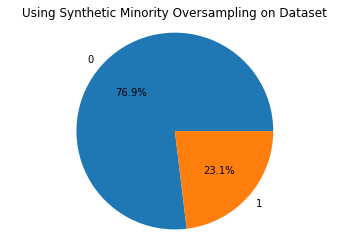

In [28]:
# Compute class distribution in y_res
class_counts = y_res.value_counts()

# Plot pie chart of class distribution
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Using Synthetic Minority Oversampling on Dataset')
plt.show()

In [29]:
X_res

,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18
0,0.703924,0.069871,-0.897198,0.396879,0.268544,0.752264,-0.252977,-3.211514,1.648897,-1.297012
1,1.347969,-0.379954,0.081125,-1.275754,-1.871478,0.375166,-0.149358,0.802805,-0.405073,0.153925
2,2.615556,2.362138,0.574245,2.035115,-0.564418,-1.407557,-0.859411,0.099132,-0.035668,-0.053624
3,0.755202,-0.963160,-0.794616,-0.939787,1.101727,1.138109,0.156943,-0.419096,-0.207755,0.403235
4,0.784402,1.254973,-0.161727,0.015787,1.084154,1.016011,0.250706,-0.130522,-0.216624,-0.058071
...,...,...,...,...,...,...,...,...,...,...
258721,-0.985755,2.722326,-1.411259,-3.270717,2.385084,-2.871336,-5.360719,-4.080189,-4.296936,-2.538650
258722,-6.885966,6.053112,-7.077575,-7.138175,3.931492,-7.895130,-7.965898,-6.710285,-12.302750,-4.777262
258723,-6.058153,5.542651,-0.915482,-3.933707,4.698235,-4.205764,-10.214972,0.482277,0.174683,1.527886
258724,-1.804850,4.793714,1.112048,0.097173,0.096039,-0.069364,-2.336520,1.667074,1.216330,0.602938


Hence, we can say that the most correlated features after resolving class imbalance using Synthetic Minority Oversampling are V14, V10, V4, V12 and V17.

### Evaluation

We make use of AUC-ROC Score, Classification Report, Accuracy and F1-Score to evaluate the performance of the classifiers

In [30]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [31]:
X_res.shape

(258726, 10)

In [32]:
y_res.shape

(258726,)

In [ ]:
rf = RandomForestClassifier(n_estimators=5, max_depth=5, min_samples_split=2)

# train the random forest classifier on the data
rf.fit(X_res.values, y_res.values)


Fitting tree 1 of 5...
Fitting the Decision Tree Classifier with 2 classes...
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Depth: 0
Samples: 258726
Features: 10
Best feature: 6
Best threshold: -2.76028342840911
Left samples: 51255
Right samples: 207471
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Depth: 1
Samples: 51255
Features: 10
Best feature: 3
Best threshold: -1.740637193285
Left samples: 47364
Right samples: 3891
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Depth: 2
Samples: 47364
Features: 10
Best feature: 4
Best threshold: 0.144562690111297
Left samples: 49
Right samples: 47315
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Featur

In [ ]:
print(rf)

y_pred = rf.predict(X_test)

We have been trying to gtrain this custom model using 5 decision trees but we have run into problems as the GPU kept getting disconnected. The above result shows fitting of 4 out of 5 trees of Random Forest and it took approximately 48 hrs to run as a result we are not able generate classification report for this.

## SKlearn Model

In [1]:
import pandas as pd
df1 = pd.read_csv('creditcard.csv')

In [4]:
X = df1.drop(labels='Class', axis=1) # Features
y = df1.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [5]:
# Use Synthetic Minority Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [8]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [7]:
mutual_infos.sort_values(ascending=False)

V14       0.535037
V10       0.464777
V12       0.456051
V17       0.438193
V4        0.427426
V11       0.404044
Amount    0.392941
V3        0.387191
V16       0.335318
V7        0.304175
V2        0.291492
V9        0.256679
Time      0.247989
V21       0.235031
V27       0.229915
V1        0.220743
V18       0.198264
V8        0.174393
V6        0.171974
V28       0.170493
V5        0.157362
V20       0.107488
V19       0.099837
V23       0.067332
V24       0.063567
V26       0.046973
V25       0.031607
V22       0.031539
V13       0.024931
V15       0.022442
dtype: float64

In [9]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [13]:
pipeline_dt = Pipeline([
('model', RFC(random_state=1))
])
# Define parameter grid
param_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
# Perform grid search
grid_dt = GridSearchCV(
    estimator=pipeline_dt, 
    param_grid=param_grid_dt, 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [5, 10, None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [14]:
grid_eval(grid_dt)

Best Score 0.9995184688814757
Best Parameter {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


In [15]:
evaluation(y_test, grid_dt, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.83      0.88       148

    accuracy                           1.00     85443
   macro avg       0.97      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9154877824656241
F1-Score
0.8785714285714286
Accuracy
0.999602073897218


The precision and recall for Class 0 are both 1.00, indicating that all legitimate transactions were correctly classified. Regarding Class 1, the precision of 0.93 suggests that 93% of the fraudulent transactions classified were actually fraudulent, and the recall of 0.83 indicates that 83% of the actual fraudulent transactions were accurately identified as such. The f1-score for Class 1, which is the harmonic mean of precision and recall, is 0.88.

The accuracy of the model on the entire dataset is 0.9996, which means that it correctly classified 99.96% of the transactions. The macro average of precision, recall, and f1-score is 0.97, 0.92, and 0.94 respectively, which implies that the model performs well for both classes. Additionally, the weighted average of precision, recall, and f1-score is 1.00, indicating excellent overall model performance.

Furthermore, the model's AUC-ROC value is 0.915, suggesting that the model is good at distinguishing between the two classes. Additionally, the F1-score of 0.879 indicates that the model has a reasonable balance between precision and recall in identifying fraudulent transactions.

### Conclusion
We have noticed that the Sklearn model took a very small fraction of time that it took for the custom class to run until 80%. Considering this and the higher F1 score and accuracy, we can say that Sklearn would be a better classifier in terms of execution time.

### Sources

Data - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud